
📊 RANGE DEGLI INDICI NELLE AREE DEI CALANCHI:

RED: Min = 16.0000, Max = 79.0000
GREEN: Min = 17.0000, Max = 74.0000
BLUE: Min = 14.0000, Max = 58.0000
NDVI: Min = 0.0000, Max = 0.6429
NDWI: Min = 1.3609, Max = 4.9600
BI: Min = 1.0000, Max = 15.9375
EVI2: Min = 0.0000, Max = 1.2766
MSI: Min = 0.0000, Max = 0.6400
NGRDI: Min = 0.0000, Max = 6.8919


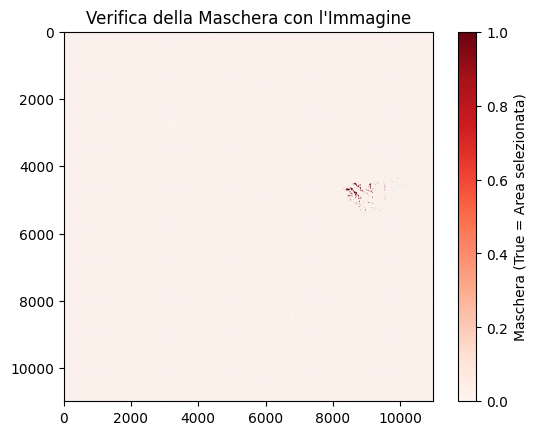

In [77]:
import dask.array as da
import rioxarray as rxr
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt


# 📌 Percorsi dei file
B2_10mt_path = 'C:/Users/geologia/Documents/Prova riconoscimento Calanchi/Bande/T33TUH_20200823T100031_B02_10m.jp2'
B3_10mt_path = 'C:/Users/geologia/Documents/Prova riconoscimento Calanchi/Bande/T33TUH_20200823T100031_B03_10m.jp2'
B4_10mt_path = 'C:/Users/geologia/Documents/Prova riconoscimento Calanchi/Bande/T33TUH_20200823T100031_B04_10m.jp2'
B8_10mt_path = 'C:/Users/geologia/Documents/Prova riconoscimento Calanchi/Bande/T33TUH_20200823T100031_B08_10m.jp2'
shp_path = 'C:/Users/geologia/Documents/Prova riconoscimento Calanchi/GIS/Calanchi_2020.shp'

# 📌 Caricamento delle bande con Dask
b2 = rxr.open_rasterio(B2_10mt_path, chunks=(1, 1024, 1024)).squeeze()
b3 = rxr.open_rasterio(B3_10mt_path, chunks=(1, 1024, 1024)).squeeze()
b4 = rxr.open_rasterio(B4_10mt_path, chunks=(1, 1024, 1024)).squeeze()
b8 = rxr.open_rasterio(B8_10mt_path, chunks=(1, 1024, 1024)).squeeze()

def normalize_band(band):
    band_min = band.min()  # Calcola il minimo
    band_max = band.max()  # Calcola il massimo
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)  # Normalizza

# Applica la normalizzazione
red_norm = normalize_band(b4)
green_norm = normalize_band(b3)
blue_norm = normalize_band(b2)
nir_norm = normalize_band(b8)

# 📌 Funzioni per gli indici spettrali
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red)

def calculate_ndwi(green, nir):
    return (green - nir) / (green + nir)

def calculate_arvi(nir, red, blue):
    return (nir - (2 * red - blue)) / (nir + (2 * red + blue) +  1e-6)

def calculate_bi(red, green, blue):
    return da.sqrt(red**2 + green**2 + blue**2)

def calculate_evi2(nir, red):
    return 2.5 * (nir - red) / (nir + 2.4 * red + 1 )

def calculate_msi(red, nir):
    return (nir - red) / (nir + red + 0.5 )

def calculate_ngrdi(green, red):
    return (green - red) / (green + red )




# 📌 Calcolo degli indici con Dask
ndvi = calculate_ndvi(nir_norm, red_norm)
ndwi = calculate_ndwi(green_norm, nir_norm)
arvi = calculate_arvi(nir_norm, red_norm, blue_norm)
bi = calculate_bi(red_norm, green_norm, blue_norm)
evi2 = calculate_evi2(nir_norm, red_norm)
msi = calculate_msi(red_norm, nir_norm)
ngrdi = calculate_ngrdi(green_norm, red_norm)

# 📌 Lettura dello shapefile con GeoPandas e riproiezione
gdf = gpd.read_file(shp_path)
if gdf.crs != blue_norm.rio.crs:
    gdf = gdf.to_crs(blue_norm.rio.crs)

# 📌 Creazione della maschera geometrica dallo shapefile
# with rasterio.open(B2_10mt_path) as src:
#     affine = src.transform
#
# geo_mask = geometry_mask(
#     geometries=gdf.geometry,
#     out_shape=(src.height, src.width),
#     transform=affine,
#     invert=True  # Mantiene i calanchi come area valida
# )

with rasterio.open(B2_10mt_path) as src:
    affine = src.transform
    geo_mask = geometry_mask(
        geometries=gdf.geometry,
        transform=affine,
        invert=True,  # Mantieni l'area dei calanchi come True
        out_shape=src.shape  # Usa la forma corretta del raster
    )


# 📌 Mascherare i dati: selezioniamo solo i pixel che ricadono nei calanchi
masked_indices = {
    "RED": red_norm.values[geo_mask],
    "GREEN": green_norm.values[geo_mask],
    "BLUE": blue_norm.values[geo_mask],
    "NDVI": ndvi.values[geo_mask],
    "NDWI": ndwi.values[geo_mask],
    # "ARVI": arvi.values[geo_mask],
    "BI": bi.values[geo_mask],
    "EVI2": evi2.values[geo_mask],
    "MSI": msi.values[geo_mask],
    "NGRDI": ngrdi.values[geo_mask]
}

# 📌 Calcolare il minimo e il massimo per ogni indice
ranges = {indice: (np.nanmin(valori), np.nanmax(valori)) for indice, valori in masked_indices.items()}

# 📌 Stampare i risultati
print("\n📊 RANGE DEGLI INDICI NELLE AREE DEI CALANCHI:\n")
for indice, (min_val, max_val) in ranges.items():
    print(f"{indice}: Min = {min_val:.4f}, Max = {max_val:.4f}")

# Visualizza la maschera sovrapposta all'immagine per verificare
plt.imshow(red_norm.values, cmap='gray')  # Mostra l'immagine del canale RED
plt.imshow(geo_mask, cmap='Reds', alpha=0.99)  # Sovrapponi la maschera in rosso
plt.title("Verifica della Maschera con l'Immagine")
plt.colorbar(label="Maschera (True = Area selezionata)")
plt.show()


In [80]:
print(f"Dimensioni dell'immagine: {red_norm.shape}")
print(f"Dimensioni della maschera: {geo_mask.shape}")


Dimensioni dell'immagine: (10980, 10980)
Dimensioni della maschera: (10980, 10980)


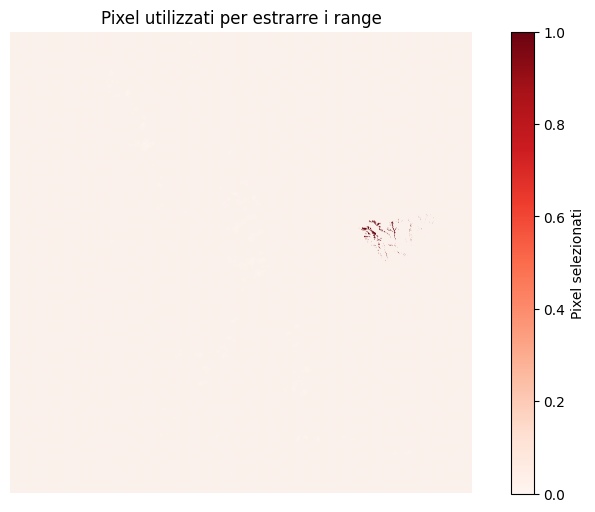

In [81]:
import numpy as np

# Creiamo un'immagine RGB combinando le bande normalizzate
rgb_image = np.dstack([red_norm, green_norm, blue_norm])

# Creiamo una maschera binaria: 1 per i pixel usati nei range, 0 per gli altri
mask_overlay = np.zeros_like(b4, dtype=np.uint8)
mask_overlay[geo_mask] = 1  # Applica la maschera dei pixel selezionati

# Plottiamo l'immagine RGB
plt.figure(figsize=(10, 6))
plt.imshow(rgb_image, cmap='gray')

# Sovrapponiamo la maschera in rosso per evidenziare i pixel selezionati
plt.imshow(mask_overlay, cmap='Reds', alpha=0.99)  # Alpha per la trasparenza
plt.title("Pixel utilizzati per estrarre i range")
plt.axis("off")
plt.colorbar(label="Pixel selezionati")
plt.show()


In [82]:
ranges_dict = {indice: (min_val, max_val) for indice, (min_val, max_val) in ranges.items()}

red_min, red_max = ranges["RED"]
green_min, green_max = ranges["GREEN"]
blue_min, blue_max = ranges["BLUE"]
ndvi_min, ndvi_max = ranges["NDVI"]
ndwi_min, ndwi_max = ranges["NDWI"]
# arvi_min, arvi_max = ranges["ARVI"]
bi_min, bi_max = ranges["BI"]
evi2_min, evi2_max = ranges["EVI2"]
msi_min, msi_max = ranges["MSI"]
ngrdi_min, ngrdi_max = ranges["NGRDI"]


In [91]:
import numpy as np

# Creiamo una maschera booleana: True se il pixel è nel range, False altrimenti
mask = (
    (red_norm >= red_min) & (red_norm <= red_max) &
    (green_norm >= green_min) & (green_norm <= green_max) &
    (blue_norm >= blue_min) & (blue_norm <= blue_max) &
    (ndvi >= ndvi_min) & (ndvi <= ndvi_max) &
    (ndwi >= ndwi_min) & (ndwi <= ndwi_max) &
    # (arvi >= arvi_min) & (arvi <= arvi_max) &
    (bi >= bi_min) & (bi <= bi_max) &
    (evi2 >= evi2_min) & (evi2 <= evi2_max) &
    (msi >= msi_min) & (msi <= msi_max) &
    (ngrdi >= ngrdi_min) & (ngrdi <= ngrdi_max)
)

# Creiamo un'immagine di output: bianco (255) per i pixel che rispettano i range, nero (0) per gli altri
classified_image = np.zeros_like(b4, dtype=np.uint8)
classified_image[mask] = 255
print(f"Pixel validi: {np.count_nonzero(mask)}")
print(f"Pixel totali: {mask.size}")


Pixel validi: 110953607
Pixel totali: 120560400


In [106]:
import numpy as np

# Creiamo una maschera booleana: True se il pixel è nel range, False altrimenti
mask = (
    (red_norm >= red_min) & (red_norm <= red_max) &
    (green_norm >= green_min) & (green_norm <= green_max) &
    (blue_norm >= blue_min) & (blue_norm <= blue_max) &
    (ndvi >= ndvi_min) & (ndvi <= ndvi_max) &
    (ndwi >= ndwi_min) & (ndwi <= ndwi_max) &
    # (arvi >= arvi_min) & (arvi <= arvi_max) &
    (bi >= bi_min) & (bi <= bi_max) &
    (evi2 >= evi2_min) & (evi2 <= evi2_max) &
    (msi >= msi_min) & (msi <= msi_max) &
    (ngrdi >= ngrdi_min) & (ngrdi <= ngrdi_max)
)


print(f"Pixel validi: {np.count_nonzero(mask)}")
print(f"Pixel totali: {mask.size}")


Pixel validi: 110953607
Pixel totali: 120560400


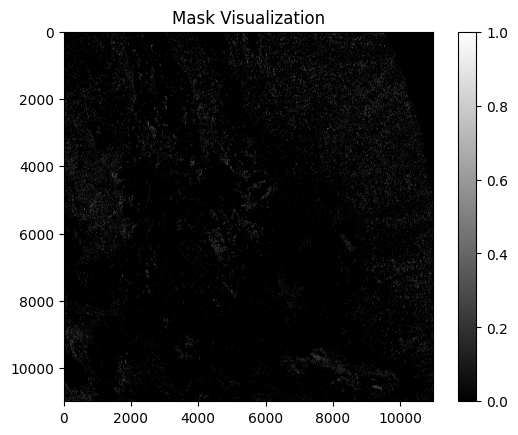

In [105]:

plt.imshow(mask.compute(), cmap="grey")  # Computa prima di visualizzare
plt.colorbar()
plt.title("Mask Visualization")
plt.show()
